## Imports

In [90]:
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np
import re
import html
import string
from collections import Counter
from itertools import chain, combinations
from nltk import word_tokenize, FreqDist, bigrams
from nltk.corpus import stopwords
from category_encoders import TargetEncoder as ce_TargetEncoder
from sklearn.preprocessing import TargetEncoder as skl_TargetEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from skopt import BayesSearchCV

# import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="The objective has been evaluated at point")

# from fuzzywuzzy import process
# from sklearn.preprocessing import MultiLabelBinarizer

# Data exploration and cleaning

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
pd.DataFrame(df_train.isnull().sum())

,0
id,0
keyword,61
location,2533
text,0
target,0


In [4]:
df_train.duplicated().sum()

np.int64(0)

In [5]:
print(f'Disasters:\t{df_train[df_train.target==1].shape[0]} ({round(df_train[df_train.target==1].shape[0]/df_train.shape[0]*100,1)}%)')
print(f'Not disasters:\t{df_train[df_train.target==0].shape[0]} ({round(df_train[df_train.target==0].shape[0]/df_train.shape[0]*100,1)}%)')

Disasters:	3271 (43.0%)
Not disasters:	4342 (57.0%)


## Keywords

In [6]:
df_train['keyword'].nunique()

221

In [7]:
pd.DataFrame(df_train[df_train['target']==1][['keyword','target']].groupby('keyword').value_counts().sort_values(ascending=False).head(10))

,,count
keyword,target,
derailment,1,39
outbreak,1,39
wreckage,1,39
debris,1,37
oil%20spill,1,37
typhoon,1,37
rescuers,1,32
suicide%20bomb,1,32
suicide%20bombing,1,32


In [8]:
pd.DataFrame(df_train[df_train['target']==0][['keyword','target']].groupby('keyword').value_counts().sort_values(ascending=False).head(10))

,,count
keyword,target,
body%20bags,0,40
armageddon,0,37
harm,0,37
deluge,0,36
ruin,0,36
wrecked,0,36
explode,0,35
fear,0,35
twister,0,35


In [9]:
df_train.groupby('keyword', as_index=False).agg(target_mean=('target','mean'), keyword_count=('target','size')).query('target_mean > 0.95').sort_values('target_mean', ascending=False).round(3)

,keyword,target_mean,keyword_count
62,debris,1.000,37
70,derailment,1.000,39
219,wreckage,1.000,39
153,outbreak,0.975,40
152,oil%20spill,0.974,38
205,typhoon,0.974,38
187,suicide%20bombing,0.970,33
186,suicide%20bomber,0.968,31


In [10]:
df_train.groupby('keyword', as_index=False).agg(target_mean=('target','mean'), keyword_count=('target','size')).query('target_mean <0.05').sort_values('target_mean', ascending=True).round(3)

,keyword,target_mean,keyword_count
2,aftershock,0.000,34
29,body%20bags,0.024,41
170,ruin,0.027,37
19,blazing,0.029,34
27,body%20bag,0.030,33
88,electrocute,0.031,32


## Locations

In [11]:
df_train['location'].nunique()

3341

In [12]:
pd.DataFrame(df_train[['location','target']].groupby('location').value_counts())
# grouped_counts = df_train[['location','target']].groupby('location').value_counts()
# grouped_counts[grouped_counts > 10].index.get_level_values('location').unique().tolist()

,,count
location,target,
,1,1
Glasgow,0,1
"Melbourne, Australia",0,1
News,1,1
å_,0,1
...,...,...
å_: ?? ÌÑ ? : ?,0,1
å_å_Los Mina Cityã¢,0,1
å¡å¡Midwest Û¢Û¢,0,1


In [13]:
pd.DataFrame(df_train[df_train['target']==1][['location','target']].groupby('location').value_counts().sort_values(ascending=False).head(10))

,,count
location,target,
USA,1,67
United States,1,27
Nigeria,1,22
India,1,20
Mumbai,1,19
UK,1,16
London,1,16
New York,1,16
"Washington, DC",1,15


In [14]:
pd.DataFrame(df_train[df_train['target']==0][['location','target']].groupby('location').value_counts().sort_values(ascending=False).head(10))

,,count
location,target,
New York,0,55
USA,0,37
London,0,29
United States,0,23
"Los Angeles, CA",0,18
Canada,0,16
Kenya,0,15
Everywhere,0,12
UK,0,11


In [15]:
df_train.groupby('location', as_index=False).agg(target_mean=('target','mean'), keyword_count=('target','size')).query('target_mean > 0.95').sort_values('target_mean', ascending=False).round(3)

,location,target_mean,keyword_count
3340,åø\_(?)_/åø,1.0,1
0,,1.0,1
3,News,1.0,1
6,"616 Û¢ Kentwood , MI",1.0,1
7,? ??????? ? ( ?? å¡ ? ? ? å¡),1.0,1
...,...,...,...
65,#partsunknown,1.0,1
63,#keepthefaith J&J,1.0,1
62,#iminchina,1.0,1
61,#goingdownthetoilet Illinois,1.0,1


In [16]:
df_train.groupby('location', as_index=False).agg(target_mean=('target','mean'), keyword_count=('target','size')).query('target_mean < 0.05').sort_values('target_mean', ascending=False).round(3)

,location,target_mean,keyword_count
3339,åÊ(?Û¢`?Û¢å«)??,0.0,1
1,Glasgow,0.0,1
2,"Melbourne, Australia",0.0,1
4,å_,0.0,1
3315,Û¢OlderCandyBloomÛ¢,0.0,1
...,...,...,...
15,"Eugene, Oregon",0.0,1
13,Blood Indian Reserve,0.0,1
11,"BC, US, Asia or Europe.",0.0,1
10,Alex/Mika/Leo|18|he/she/they,0.0,1


In [17]:
df_train.groupby('location', as_index=False)['target'].mean().query('target > 0.75 & target < 1.0').sort_values('target', ascending=False)
# ['location'].unique().tolist()

,location,target
1719,Mumbai,0.863636
1262,India,0.833333
1934,"Oklahoma City, OK",0.833333
2028,"Paterson, New Jersey",0.833333
2032,Pedophile hunting ground,0.833333
1426,"Lagos, Nigeria",0.800000
1636,"Melbourne, Australia",0.800000
2124,Puerto Rico,0.800000
2538,The Netherlands,0.800000
2866,WorldWide,0.800000


In [18]:
df_train.groupby('location', as_index=False)['target'].mean().query('target > 0.0 & target < 0.25').sort_values('target', ascending=True)
# ['location'].unique().tolist()

,location,target
1511,"London, England",0.100000
3222,ss,0.100000
578,"California, United States",0.166667
27,Road to the Billionaires Club,0.166667
1759,NYC,0.166667
525,"Brooklyn, NY",0.166667
495,Brasil,0.200000
484,"Boston, MA",0.200000
2255,"San Jose, CA",0.200000
934,Everywhere,0.200000


In [19]:
df_train.groupby('location', as_index=False).agg(target_mean=('target','mean'), keyword_count=('target','size')).query('keyword_count >= 5').sort_values(['target_mean','keyword_count'], ascending=[False,False]).head(5).round(3)

,location,target_mean,keyword_count
1719,Mumbai,0.864,22
1262,India,0.833,24
1934,"Oklahoma City, OK",0.833,6
2028,"Paterson, New Jersey",0.833,6
2032,Pedophile hunting ground,0.833,6


In [20]:
df_train.groupby('location', as_index=False).agg(target_mean=('target','mean'), keyword_count=('target','size')).query('keyword_count >= 5').sort_values(['target_mean','keyword_count'], ascending=[True,False]).head(5).round(3)

,location,target_mean,keyword_count
114,304,0.0,9
2039,"Pennsylvania, USA",0.0,7
1708,"Morioh, Japan",0.0,6
728,Coventry,0.0,5
1263,Indiana,0.0,5


In [21]:
# df_train['cleaned_location'] = df_train['location']
# df_train['cleaned_location'] = df_train['cleaned_location'].fillna('unknown')

# standard_locations = ['Canada','Florida','India','Kenya','London','Los Angeles, CA','Mumbai','New York','Nigeria','UK','USA','United States','Washington, DC','Oklahoma City, OK','Paterson, New Jersey','Lagos, Nigeria','Melbourne, Australia','Puerto Rico','The Netherlands','Nashville, TN','London, England','California, United States','NYC','Brooklyn, NY','Brasil','Boston, MA','San Jose, CA','New York, USA','New Jersey','Vancouver, BC','Manchester']

# def generate_location_mapping(train_locations, standard_locations):
#     location_mapping = {}
#     for loc in train_locations:
#         match, score = process.extractOne(loc, standard_locations)
#         location_mapping[loc] = match if score > 90 else loc
#     return location_mapping

# unique_train_locations = df_train['cleaned_location'].unique()
# location_mapping = generate_location_mapping(unique_train_locations, standard_locations)

# def clean_locations(location, mapping):
#     return mapping.get(location, location)

# df_train['cleaned_location'] = df_train['cleaned_location'].apply(lambda x: clean_locations(x, location_mapping))

# df_train[(df_train['cleaned_location'] != df_train['location']) & (df_train['cleaned_location'] != 'unknown')][['location','cleaned_location']]

## Text

### Clean

In [22]:
def remove_newlines(text): return re.sub(r'\n', ' ', text).strip()

def fix_html_entities(text): return html.unescape(text)

def extract_elements(text, element_type):
    patterns = {  'hashtags': r'#[A-Za-z0-9-_]+',
                  'handles': r'@[A-Za-z0-9-_]+',
                  'urls': r'https?://t.co/[A-Za-z0-9]{10}'  }
    pattern = re.compile(patterns[element_type])
    elements = pattern.findall(text)
    n = len(elements)
    elements_str = ' '.join(elements).lower()
    new_text = pattern.sub('', text)
    return new_text.strip(), elements_str, n

In [23]:
df_train['text_clean'] = df_train['text'].apply(lambda x: remove_newlines(x))
df_train['text_clean'] = df_train['text_clean'].apply(lambda x: fix_html_entities(x))
df_train[['text_clean', 'hashtags', 'n_hashtags']] = df_train['text_clean'].apply(lambda x: extract_elements(x,'hashtags')).apply(pd.Series)
df_train[['text_clean', 'handles', 'n_handles']] = df_train['text_clean'].apply(lambda x: extract_elements(x,'handles')).apply(pd.Series)
df_train[['text_clean', 'urls', 'n_urls']] = df_train['text_clean'].apply(lambda x: extract_elements(x,'urls')).apply(pd.Series)

In [24]:
df_train[(df_train['text_clean'] != df_train['text']) & (df_train['n_hashtags'] >= 2) & (df_train['n_handles'] >= 1) & (df_train['n_urls'] >= 1)][['text','text_clean','hashtags','n_hashtags','handles','n_handles','urls','n_urls']]

,text,text_clean,hashtags,n_hashtags,handles,n_handles,urls,n_urls
104,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,320 [IR] ICEMOON [AFTERSHOCK] | | | Û_,#dubstep #trapmusic #dnb #edm #dance #ices,6,@djicemoon,1,http://t.co/ynxnvvkcda http://t.co/weqpesenku,2
106,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,320 [IR] ICEMOON [AFTERSHOCK] | | | Û_,#dubstep #trapmusic #dnb #edm #dance #ices,6,@djicemoon,1,http://t.co/vam5podgyw http://t.co/zevakjapcz,2
114,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...,320 [IR] ICEMOON [AFTERSHOCK] | | | Û_,#dubstep #trapmusic #dnb #edm #dance #ices,6,@djicemoon,1,http://t.co/m4jdzmgjow http://t.co/n0uhasfkbv,2
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,320 [IR] ICEMOON [AFTERSHOCK] | | | Û_,#dubstep #trapmusic #dnb #edm #dance #ices,6,@djicemoon,1,http://t.co/vam5podgyw http://t.co/zevakjapcz,2
116,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...,320 [IR] ICEMOON [AFTERSHOCK] | | | Û_,#dubstep #trapmusic #dnb #edm #dance #ices,6,@djicemoon,1,http://t.co/e14epzhoth http://t.co/22a9d5do6q,2
...,...,...,...,...,...,...,...,...
6993,This is my jam: Riser by Dierks Bentley @1061T...,This is my jam: Riser by Dierks Bentley ?,#iheartradio #nowplaying,2,@1061thetwister,1,http://t.co/zqoscqd64h http://t.co/ylvvf139bb,2
7022,#breaking #news Global precipitation measureme...,Global precipitation measurement satellite cap...,#breaking #news,2,@nasahurricane,1,http://t.co/20dncthr4d,1
7279,Whirlwind Head Scissor on @alexhammerstone @kt...,Whirlwind Head Scissor on ktfounder Û_,#remymarcel #frofrofro,2,@alexhammerstone @kttape,2,https://t.co/b19z8vi3td,1
7406,Twilight's Encore (Wounded Hearts Book 3) by J...,Twilight's Encore (Wounded Hearts Book 3) by J...,#kindlecountdown #sale #mfrwauthor #mgtab,4,@amazon,1,http://t.co/znptdicqxe,1


In [25]:
# for element in ['hashtags', 'handles', 'urls']:
#     mlb = MultiLabelBinarizer()
#     one_hot = pd.DataFrame(mlb.fit_transform(df_train[element]), columns=mlb.classes_, index=df_train.index)
#     # df_train = pd.concat([df_train, one_hot], axis=1)
#     display(one_hot)

### Frequencies

In [26]:
len(set(' '.join(df_train['text_clean']).lower().split()))

19134

In [27]:
disaster_clean_text = ' '.join(df_train[df_train['target']==1]['text_clean']).lower()
notdisaster_clean_text = ' '.join(df_train[df_train['target']==0]['text_clean']).lower()

### Unigrams

In [28]:
nltkstopwords = stopwords.words('english')

disaster_tokens = [w for w in word_tokenize(disaster_clean_text) if (w not in nltkstopwords) & (w.isalpha())]
notdisaster_tokens = [w for w in word_tokenize(notdisaster_clean_text) if (w not in nltkstopwords) & (w.isalpha())]

top_disaster_tokens = FreqDist(disaster_tokens).most_common(20)
top_notdisaster_tokens = FreqDist(notdisaster_tokens).most_common(20)
display(pd.DataFrame(top_disaster_tokens, columns=['Disaster Token', 'Frequency']).head(10))
display(pd.DataFrame(top_notdisaster_tokens, columns=['Non-Disaster Token', 'Frequency']).head(10))

top_disaster_words = [w for w,f in top_disaster_tokens]
top_nondisaster_words = [w for w,f in top_notdisaster_tokens]
display(', '.join([w for w in top_disaster_words if w not in top_nondisaster_words]))
display(', '.join([w for w in top_nondisaster_words if w not in top_disaster_words]))

,Disaster Token,Frequency
0,fire,175
1,via,121
2,disaster,111
3,california,107
4,police,106
5,suicide,104
6,people,103
7,like,93
8,killed,92
9,storm,85


,Non-Disaster Token,Frequency
0,like,253
1,new,168
2,get,162
3,one,129
4,body,110
5,would,105
6,via,97
7,video,94
8,got,92
9,people,92


'fire, disaster, california, police, suicide, killed, storm, crash, news, fires, families, train, buildings, bomb, two, attack'

'new, get, one, body, would, video, got, love, know, back, time, see, full, day, going, ca'

### Bigrams

In [29]:
disaster_bigrams = [' '.join(b) for b in list(bigrams(disaster_tokens))]
nondisaster_bigrams = [' '.join(b) for b in list(bigrams(notdisaster_tokens))]

top_disaster_bigrams = FreqDist(disaster_bigrams).most_common(20)
top_nondisaster_bigrams = FreqDist(nondisaster_bigrams).most_common(20)
display(pd.DataFrame(top_disaster_bigrams, columns=['Disaster Token', 'Frequency']).head(10))
display(pd.DataFrame(top_nondisaster_bigrams, columns=['Non-Disaster Token', 'Frequency']).head(10))

top_disaster_bigrams = [w for w,f in top_disaster_bigrams]
top_nondisaster_bigrams = [w for w,f in top_nondisaster_bigrams]
display(' | '.join([w for w in top_disaster_bigrams if w not in top_nondisaster_bigrams]))
display(' | '.join([w for w in top_nondisaster_bigrams if w not in top_disaster_bigrams]))

,Disaster Token,Frequency
0,suicide bomber,59
1,northern california,41
2,oil spill,38
3,burning buildings,35
4,suicide bombing,32
5,california wildfire,32
6,bomber detonated,30
7,homes razed,29
8,latest homes,28
9,razed northern,28


,Non-Disaster Token,Frequency
0,cross body,38
1,liked video,34
2,gon na,32
3,wan na,30
4,body bag,26
5,body bagging,23
6,burning buildings,23
7,full read,22
8,looks like,21
9,feel like,20


'suicide bomber | northern california | oil spill | suicide bombing | california wildfire | bomber detonated | homes razed | latest homes | razed northern | pkk suicide | detonated bomb | old pkk | debris found | mass murder | families sue | sue legionnaires | legionnaires families | families affected | affected fatal'

'cross body | liked video | gon na | wan na | body bag | body bagging | full read | looks like | feel like | content policy | body bags | loud bang | reddit quarantine | quarantine offensive | offensive content | pick fan | fan army | fall cliff | first responders'

### Hashtags

In [30]:
len(set(' '.join(df_train['hashtags']).split()))

1926

In [31]:
pd.DataFrame(df_train[df_train['target']==1][['hashtags','target']].groupby('hashtags').value_counts().sort_values(ascending=False).head(10))

,,count
hashtags,target,
,1,2413
#hot #prebreak #best,1,13
#news,1,12
#earthquake,1,8
#worldnews,1,8
#hiroshima,1,8
#wx,1,7
#antioch,1,6
#bestnaijamade,1,6


In [32]:
pd.DataFrame(df_train[df_train['target']==0][['hashtags','target']].groupby('hashtags').value_counts().sort_values(ascending=False).head(10))

,,count
hashtags,target,
,0,3457
#hot #prebreak #best,0,17
#gbbo,0,11
#nowplaying,0,10
#beyhive,0,8
#directioners,0,7
#dubstep #trapmusic #dnb #edm #dance #ices,0,7
#animalrescue,0,7
#handbag #womens,0,5


### Handles

In [33]:
len(set(' '.join(df_train['handles']).split()))

2316

In [34]:
pd.DataFrame(df_train[df_train['target']==1][['handles','target']].groupby('handles').value_counts().sort_values(ascending=False).head(10))

,,count
handles,target,
,1,2605
@youtube,1,17
@usatoday,1,4
@potus,1,4
@foxnews,1,4
@change,1,4
@sharethis,1,3
@viralspell,1,3
@smh,1,3


In [35]:
pd.DataFrame(df_train[df_train['target']==0][['handles','target']].groupby('handles').value_counts().sort_values(ascending=False).head(10))

,,count
handles,target,
,0,2999
@youtube,0,44
@djicemoon,0,7
@change,0,5
@emmerdale,0,4
@mikeparractor,0,4
@raynbowaffair @diamondkesawn,0,4
@usatoday,0,4
@worldnetdaily,0,4


### URLs

In [36]:
len(set(' '.join(df_train['urls']).split()))

4593

In [37]:
pd.DataFrame(df_train[df_train['target']==1][['urls','target']].groupby('urls').value_counts().sort_values(ascending=False).head(10))

,,count
urls,target,
,1,1100
http://t.co/ksawlyux02,1,6
http://t.co/lvlh3w3awo http://t.co/viwxy1xdyk,1,4
http://t.co/cybksxhf7d,1,3
http://t.co/cedcugeuws,1,3
http://t.co/v3azwoamzk,1,3
https://t.co/rqwuoy1fm4,1,3
http://t.co/eysvvza7qm,1,2
http://t.co/edyfo6e2pu http://t.co/m5kxlpkfa1,1,2


In [38]:
pd.DataFrame(df_train[df_train['target']==0][['urls','target']].groupby('urls').value_counts().sort_values(ascending=False).head(10))

,,count
urls,target,
,0,2543
http://t.co/qew4c5m1xd,0,9
http://t.co/q2eblokeve http://t.co/encmhz6y34,0,5
http://t.co/nnmqlz91o9 http://t.co/o91f3cyy0r,0,4
http://t.co/thoyhrhkfj http://t.co/wvj39a3bgm,0,4
https://t.co/dehmym5lpk,0,3
https://t.co/moll5vd8yd,0,3
http://t.co/bbdpnj8xsx,0,2
http://t.co/io7kuug1uq,0,2


# Feature engineering

## Stats

In [39]:
def char_count(text): return len(text)

def word_count(text): return len(text.split())

def unique_word_count(text): return len(set(text.split()))

def avg_word_length(text): return round(sum(len(word) for word in text.split()) / len(text.split()),3)

def punctuation_count(text): return len([n for n in text if n in string.punctuation])

def stopwords_count(text): return len([n for n in text.lower() if n in nltkstopwords])

def caps_count(text): return sum([1 for n in text if n.isupper()])

def repeated_words(text):
    word_counts = Counter(text.split())
    return ' '.join([word for word, count in word_counts.items() if count > 1 and word.lower() not in nltkstopwords])

In [40]:
df_train['char_count'] = df_train['text_clean'].apply(lambda x: char_count(x))
df_train['word_count'] = df_train['text_clean'].apply(lambda x: word_count(x))
df_train['unique_word_count'] = df_train['text_clean'].apply(lambda x: unique_word_count(x))
df_train['avg_word_length'] = df_train['text_clean'].apply(lambda x: avg_word_length(x))
df_train['punctuation_count'] = df_train['text_clean'].apply(lambda x: punctuation_count(x))
df_train['stopwords_count'] = df_train['text_clean'].apply(lambda x: stopwords_count(x))
df_train['caps_count'] = df_train['text_clean'].apply(lambda x: caps_count(x))
# df_train['repeated_words'] = df_train['text_clean'].apply(lambda x: repeated_words(x))

In [41]:
df_train[['char_count','word_count','unique_word_count','avg_word_length','punctuation_count','stopwords_count','caps_count']].describe().round(3)

,char_count,word_count,unique_word_count,avg_word_length,punctuation_count,stopwords_count,caps_count
count,7613.000,7613.000,7613.000,7613.000,7613.000,7613.000,7613.000
mean,78.132,13.557,12.995,4.958,2.828,29.017,6.230
std,32.195,5.908,5.429,1.079,3.013,12.626,9.246
min,4.000,1.000,1.000,2.000,0.000,0.000,0.000
25%,54.000,9.000,9.000,4.250,1.000,20.000,2.000
50%,78.000,13.000,13.000,4.812,2.000,29.000,4.000
75%,104.000,18.000,17.000,5.500,4.000,38.000,7.000
max,157.000,31.000,29.000,19.333,55.000,71.000,118.000


## Polynomial Features

In [42]:
def poly_features(df, poly=None):
    cols = ['n_handles','n_hashtags','n_urls','char_count','word_count','unique_word_count','avg_word_length','punctuation_count','stopwords_count','caps_count']
    numerical_features = df[cols]
    if poly is None:
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly.fit(numerical_features)
    poly_features = poly.transform(numerical_features)
    poly_feature_names = poly.get_feature_names_out(numerical_features.columns)
    df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    df_poly = df_poly.loc[:, ~df_poly.columns.isin(numerical_features.columns)]
    return pd.concat([df, df_poly], axis=1), poly

df_train, poly = poly_features(df_train)

In [43]:
pd.DataFrame(df_train.iloc[0][['char_count^2','char_count word_count','char_count unique_word_count','char_count avg_word_length','char_count punctuation_count','char_count stopwords_count','char_count caps_count']]).T

,char_count^2,char_count word_count,char_count unique_word_count,char_count avg_word_length,char_count punctuation_count,char_count stopwords_count,char_count caps_count
0,3364.0,696.0,696.0,222.314,0.0,1276.0,580.0


In [44]:
pd.DataFrame(df_train.select_dtypes(include=['number']).drop('id', axis=1).corr()['target'].drop('target').sort_values(ascending=False).round(3))

,target
n_urls stopwords_count,0.246
n_urls char_count,0.228
n_urls avg_word_length,0.212
avg_word_length stopwords_count,0.210
n_urls unique_word_count,0.205
...,...
n_handles word_count,-0.082
n_handles unique_word_count,-0.082
n_handles avg_word_length,-0.085
n_handles punctuation_count,-0.086


## Category Encoding

In [45]:
features = ['keyword', 'location']
# features = ['keyword', 'cleaned_location']

In [46]:
ce_encoder = ce_TargetEncoder(cols=features)
ce_transformed_df = ce_encoder.fit_transform(df_train[features], df_train['target']).add_suffix('_target_ce')
df_train = df_train.join(ce_transformed_df)

In [47]:
skl_encoder = skl_TargetEncoder(categories='auto', target_type='binary', smooth='auto', cv=5, random_state=42)
skl_transformed = skl_encoder.fit_transform(df_train[features], df_train['target'])
skl_transformed_df = pd.DataFrame(skl_transformed, columns=[f"{col}_target_skl" for col in features], index=df_train.index)
df_train = df_train.join(skl_transformed_df)

In [48]:
pd.DataFrame(df_train[df_train['location']=='London'][['location','location_target_ce','location_target_skl']]).head(10)

,location,location_target_ce,location_target_skl
227,London,0.361177,0.369915
241,London,0.361177,0.369915
495,London,0.361177,0.273662
784,London,0.361177,0.335522
803,London,0.361177,0.273662
1158,London,0.361177,0.273662
1391,London,0.361177,0.437261
1532,London,0.361177,0.369915
1831,London,0.361177,0.383659
2064,London,0.361177,0.437261


In [49]:
pd.DataFrame(df_train[df_train['location']=='London'][['target','location_target_skl']].groupby('location_target_skl').value_counts()).sort_values(['location_target_skl','target'])

count
location_target_skl target       
0.273662            0           2
                    1           6
0.335522            0           3
                    1           3
0.369915            0           5
                    1           2
0.383659            0           8
                    1           3
0.437261            0          11
                    1           2

In [50]:
pd.DataFrame(df_train[df_train['location']=='London'][['target','location_target_skl']].groupby('target').mean())

,location_target_skl
target,
0,0.389055
1,0.338366


## Feature Extraction: CountVectorizer

In [51]:
vec_hashtags = CountVectorizer(min_df=4)
df_train_hashtags_vectorised = vec_hashtags.fit_transform(df_train['hashtags'])
df_train_hashtags_vectorised_df = pd.DataFrame(df_train_hashtags_vectorised.toarray(), columns=vec_hashtags.get_feature_names_out())

vec_handles = CountVectorizer(min_df=2)
df_train_handles_vectorised = vec_handles.fit_transform(df_train['handles'])
df_train_handles_vectorised_df = pd.DataFrame(df_train_handles_vectorised.toarray(), columns=vec_handles.get_feature_names_out())

vec_urls = CountVectorizer(min_df=2, token_pattern=r'https?://t.co/[A-Za-z0-9]{10}')
df_train_urls_vectorised = vec_urls.fit_transform(df_train['urls'])
df_train_urls_vectorised_df = pd.DataFrame(df_train_urls_vectorised.toarray(), columns=vec_urls.get_feature_names_out())

print(f'{df_train_hashtags_vectorised_df.shape[1]} {df_train_handles_vectorised_df.shape[1]} {df_train_urls_vectorised_df.shape[1]}')

150 169 72


In [52]:
pd.DataFrame(df_train_hashtags_vectorised_df.transpose().dot(df_train['target']) / df_train_hashtags_vectorised_df.sum(axis=0)).sort_values(0, ascending=False)

,0
abstorm,1.0
accident,1.0
africa,1.0
breaking,1.0
bestnaijamade,1.0
...,...
np,0.0
trapmusic,0.0
technology,0.0
soundcloud,0.0


In [53]:
pd.DataFrame(df_train_handles_vectorised_df.transpose().dot(df_train['target']) / df_train_handles_vectorised_df.sum(axis=0)).sort_values(0, ascending=False)

,0
9newsgoldcoast,1.0
abc,1.0
_minimehh,1.0
cjoyner,1.0
cityofcalgary,1.0
...,...
weyrey_gidi,0.0
wired,0.0
worldnetdaily,0.0
ymcglaun,0.0


In [54]:
pd.DataFrame(df_train_urls_vectorised_df.transpose().dot(df_train['target']) / df_train_urls_vectorised_df.sum(axis=0)).sort_values(0, ascending=False)

,0
http://t.co/199t7nd0pm,1.0
http://t.co/3sicroaanz,1.0
http://t.co/i27oa0hisp,1.0
http://t.co/dydfvz7amj,1.0
http://t.co/cgf61fpmr0,1.0
...,...
http://t.co/yduixefipe,0.0
https://t.co/is2idc3ubj,0.0
https://t.co/dehmym5lpk,0.0
https://t.co/lfkmtzaekk,0.0


In [55]:
df_train = df_train.join(df_train_hashtags_vectorised_df, rsuffix='_hashtags')
df_train = df_train.join(df_train_handles_vectorised_df, rsuffix='_handles')
df_train = df_train.join(df_train_urls_vectorised_df, rsuffix='_urls')

## Feature Extraction: TfidfVectorizer

In [56]:
df_train['word_count'].mean()

np.float64(13.557467489820045)

In [57]:
vec_text = TfidfVectorizer(min_df=10, ngram_range=(1,5), stop_words='english') 
df_train_text_clean_vectorised = vec_text.fit_transform(df_train['text_clean'])
df_train_text_clean_vectorised_df = pd.DataFrame(df_train_text_clean_vectorised.toarray(), columns=vec_text.get_feature_names_out())

print(df_train_text_clean_vectorised_df.shape[1])

2148


In [58]:
pd.DataFrame(df_train_text_clean_vectorised_df.transpose().dot(df_train['target']) / df_train_text_clean_vectorised_df.sum(axis=0)).sort_values(0, ascending=False)

,0
migrants,1.0
detonated,1.0
village,1.0
legionnaires,1.0
15 saudi security site,1.0
...,...
welcome,0.0
aftershock,0.0
womens,0.0
disney,0.0


In [59]:
df_train = df_train.join(df_train_text_clean_vectorised_df, rsuffix='_text')

# Modelling

### Init

In [60]:
lr = LogisticRegression(random_state=42, solver='liblinear')

cv_scores = []

### Prep X, y

In [61]:
# features_to_drop = df_train.select_dtypes(exclude=['number']).columns.to_list()
# features_to_drop.extend(['id'])

# X_train = df_train.drop(columns=features_to_drop+['target'])
# y_train = df_train['target']

In [62]:
features_stats = ['char_count','word_count','unique_word_count','avg_word_length','punctuation_count','stopwords_count','caps_count','n_handles','n_hashtags','n_urls',]
features_polys = list(poly.get_feature_names_out())
features_te_ce = ['keyword_target_ce','location_target_ce']
features_te_skl = ['keyword_target_skl','location_target_skl']
features_cv_hashtags = list(vec_hashtags.get_feature_names_out())
features_cv_handles = list(vec_handles.get_feature_names_out())
features_cv_urls = list(vec_urls.get_feature_names_out())
features_cv = features_cv_hashtags + features_cv_handles + features_cv_urls
features_tv = list(vec_text.get_feature_names_out())

features_to_keep = features_stats + features_polys + features_te_ce + features_te_skl + features_cv + features_tv
features_to_keep.remove('text')

X_train = df_train[features_to_keep]
y_train = df_train['target']

### First run

In [63]:
def crossval(stage):
    cross_val_f1 = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1')
    print(f'Cross-validated F1 score: {round(cross_val_f1.mean(),4)} (range = {(cross_val_f1.max()-cross_val_f1.min()).round(4)})')
    cv_scores.append((stage,cross_val_f1.mean()))

In [64]:
crossval('Initial')

Cross-validated F1 score: 0.6647 (range = 0.1585)


### SMOTE

In [65]:
print(f'Positives: {df_train[df_train.target==1].shape[0]} ({round(df_train[df_train.target==1].shape[0]/df_train.shape[0]*100,1)}%)')
print(f'Negatives: {df_train[df_train.target==0].shape[0]} ({round(df_train[df_train.target==0].shape[0]/df_train.shape[0]*100,1)}%)')
print(f'X number of rows: {X_train.shape[0]}')
print()

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f'Positives: {int(y_train[y_train==1].count())} ({round(int(y_train[y_train==1].count())/int(y_train.count())*100,1)}%)')
print(f'Negatives: {int(y_train[y_train==0].count())} ({round(int(y_train[y_train==0].count())/int(y_train.count())*100,1)}%)')
print(f'X number of rows: {y_train.shape[0]}')
print()

crossval('SMOTE')

Positives: 3271 (43.0%)
Negatives: 4342 (57.0%)
X number of rows: 7613

Positives: 4342 (50.0%)
Negatives: 4342 (50.0%)
X number of rows: 8684

Cross-validated F1 score: 0.7343 (range = 0.2013)


### Scale

In [66]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

crossval('Scale')

Cross-validated F1 score: 0.8348 (range = 0.109)


### Feature Selection: Select K Best

In [67]:
# selector_pipeline = Pipeline([('select',SelectKBest(score_func=chi2)), ('clf',lr)])
# bayessearch_selector = BayesSearchCV(estimator=selector_pipeline, search_spaces={'select__k':(1,X_train.shape[1])}, n_iter=100, scoring='f1', cv=5, verbose=0, n_jobs=-1)
# bayessearch_selector.fit(X_train, y_train)
# print("Best k:", bayessearch_selector.best_params_['select__k'])
# print("Best F1 score:", bayessearch_selector.best_score_)
# selector_kb = bayessearch_selector.best_estimator_[0]
selector_kb = SelectKBest(score_func=chi2, k=50)
X_train = selector_kb.fit_transform(X_train, y_train)

crossval('SKB')

Cross-validated F1 score: 0.8634 (range = 0.0646)


### Feature Selection: Variance Threshold

In [68]:
# from sklearn.feature_selection import VarianceThreshold
# selector_vt = VarianceThreshold(threshold=0.01)
# X_train = selector_vt.fit_transform(X_train, y_train)

# crossval('VT')

### Feature Selection: RFECV

In [69]:
# rfecv = RFECV(estimator=lr, step=10, cv=5, scoring='f1')
# rfecv.fit(X_train, y_train)

# plt.figure(figsize=(6,3))
# plt.xlabel("Number of features selected")
# plt.ylabel("Number of correct classifications)")
# plt.plot(rfecv.cv_results_['n_features'], rfecv.cv_results_['mean_test_score'])
# plt.show()

# print("Optimal number of features:", rfecv.n_features_)
# # rfecv_features = rfecv.support_
# # print("Selected features:", rfecv_features)
# # print("Selected features:", X_train.columns[rfecv_features])
# # print("Feature rankings:", rfecv.ranking_)

# X_train = rfecv.transform(X_train)

# crossval('RFECV')

### Logistic Regressor

In [70]:
# param_grid = [{'solver':['liblinear'], 'penalty':['l1','l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
# gridsearch_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=100), param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1)
# gridsearch_lr.fit(X_train, y_train)
# print(f'Best score: {gridsearch_lr.best_score_}')
# print(f'Best parameters: {gridsearch_lr.best_params_}')

In [71]:
# search_spaces = [{'solver':['liblinear'], 'penalty':['l1','l2'], 'C':(0.01, 10, 'log-uniform')}]
# bayessearch_lr = BayesSearchCV(LogisticRegression(random_state=42), search_spaces=search_spaces, n_iter=50, scoring='f1', cv=5, n_jobs=-1)
# bayessearch_lr.fit(X_train, y_train)
# print(f'Best score: {bayessearch_lr.best_score_}')
# print(f'Best parameters: {bayessearch_lr.best_params_}')

In [72]:
# lr = gridsearch_lr.best_estimator_
lr = LogisticRegression(random_state=42, C=0.1, penalty='l1', solver='liblinear')
# lr = bayessearch_lr.best_estimator_
# lr = LogisticRegression(random_state=42, C=0.3019007162229442, penalty='l1', solver='liblinear')

crossval('LR')

Cross-validated F1 score: 0.8604 (range = 0.0534)


### Cross-validated F1 scores

In [73]:
pd.DataFrame(cv_scores, columns=['Stage','F1']).round(4)

,Stage,F1
0,Initial,0.6647
1,SMOTE,0.7343
2,Scale,0.8348
3,SKB,0.8634
4,LR,0.8604


## Pipeline

In [74]:
# pipeline = Pipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('scaler', MinMaxScaler()),
#     ('feature_selection', SelectKBest(score_func=chi2)),
#     ('clf', LogisticRegression(random_state=42))
# ])

# param_grid = {
#     'feature_selection__k': (1, X_train.shape[1]),
#     'clf__solver': ['liblinear'],
#     'clf__penalty': ['l1', 'l2'],
#     'clf__C': (1e-4, 1e4, 'log-uniform')
# }

# bayes_search = BayesSearchCV(
#     estimator=pipeline,
#     search_spaces=param_grid,
#     n_iter=100,
#     scoring='f1',
#     cv=10,
#     n_jobs=-1,
#     verbose=0
# )

# bayes_search.fit(X_train, y_train)
# best_pipeline = bayes_search.best_estimator_

# rfecv = RFECV(estimator=best_pipeline.named_steps['clf'], step=5, cv=10, scoring='f1')
# X_train_rfecv = rfecv.fit_transform(best_pipeline[:-1].fit_transform(X_train, y_train), y_train)

# cross_val_f1 = cross_val_score(best_pipeline.named_steps['clf'], X_train, y_train, cv=10, scoring='f1').mean()
# print(f'Cross-validated F1 score:\t{round(cross_val_f1,4)}')

# Test

In [75]:
df_test = pd.read_csv('test_X.csv')
y_test = pd.read_csv('test_y.csv')
y_true = df_test.set_index('id').join((y_test['choose_one']=='Relevant').astype(int))['choose_one']

In [76]:
# df_test['cleaned_location'] = df_test['location']
# df_test['cleaned_location'] = df_test['cleaned_location'].fillna('unknown')
# df_test['cleaned_location'] = df_test['cleaned_location'].apply(lambda x: clean_locations(x, location_mapping))

df_test['text_clean'] = df_test['text'].apply(lambda x: remove_newlines(x))
df_test['text_clean'] = df_test['text_clean'].apply(lambda x: fix_html_entities(x))
df_test[['text_clean', 'hashtags', 'n_hashtags']] = df_test['text_clean'].apply(lambda x: extract_elements(x,'hashtags')).apply(pd.Series)
df_test[['text_clean', 'handles', 'n_handles']] = df_test['text_clean'].apply(lambda x: extract_elements(x,'handles')).apply(pd.Series)
df_test[['text_clean', 'urls', 'n_urls']] = df_test['text_clean'].apply(lambda x: extract_elements(x,'urls')).apply(pd.Series)
df_test['char_count'] = df_test['text_clean'].apply(lambda x: char_count(x))
df_test['word_count'] = df_test['text_clean'].apply(lambda x: word_count(x))
df_test['unique_word_count'] = df_test['text_clean'].apply(lambda x: unique_word_count(x))
df_test['avg_word_length'] = df_test['text_clean'].apply(lambda x: avg_word_length(x))
df_test['punctuation_count'] = df_test['text_clean'].apply(lambda x: punctuation_count(x))
df_test['stopwords_count'] = df_test['text_clean'].apply(lambda x: stopwords_count(x))
df_test['caps_count'] = df_test['text_clean'].apply(lambda x: caps_count(x))

df_test, _ = poly_features(df_test, poly=poly)

df_test = df_test.join(ce_encoder.transform(df_test[features]).add_suffix('_target_ce'))
df_test = df_test.join(pd.DataFrame(skl_encoder.transform(df_test[features]), columns=[f"{col}_target_skl" for col in features], index=df_test.index))

df_test_hashtags_vectorised = vec_hashtags.transform(df_test['hashtags'])
df_test_hashtags_vectorised_df = pd.DataFrame(df_test_hashtags_vectorised.toarray(), columns=vec_hashtags.get_feature_names_out())
df_test_handles_vectorised = vec_handles.transform(df_test['handles'])
df_test_handles_vectorised_df = pd.DataFrame(df_test_handles_vectorised.toarray(), columns=vec_handles.get_feature_names_out())
df_test_urls_vectorised = vec_urls.transform(df_test['urls'])
df_test_urls_vectorised_df = pd.DataFrame(df_test_urls_vectorised.toarray(), columns=vec_urls.get_feature_names_out())
df_test_text_clean_vectorised = vec_text.transform(df_test['text_clean'])
df_test_text_clean_vectorised_df = pd.DataFrame(df_test_text_clean_vectorised.toarray(), columns=vec_text.get_feature_names_out())

df_test = df_test.join(df_test_hashtags_vectorised_df, rsuffix='_urls')
df_test = df_test.join(df_test_handles_vectorised_df, rsuffix='_handles')
df_test = df_test.join(df_test_urls_vectorised_df, rsuffix='_hashtags')
df_test = df_test.join(df_test_text_clean_vectorised_df, rsuffix='_text')

In [78]:
# X_test = df_test.drop(columns=features_to_drop)
X_test = df_test[features_to_keep]
X_test = scaler.transform(X_test)
X_test = selector_kb.transform(X_test)
# X_test = selector_vt.transform(X_test)
# X_test = rfecv.transform(X_test)

In [79]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [96]:
print(f'Accuracy: {round(accuracy_score(y_true, y_pred),3)}')
print(f'F1 score: {round(f1_score(y_true, y_pred),3)}')
cm = confusion_matrix(y_true, y_pred)
display(pd.DataFrame(cm,index=['Actual Negative', 'Actual Positive'],columns=['Predicted Negative', 'Predicted Positive']))
display(pd.DataFrame((cm/cm.sum()*100).round(1),index=['Actual Negative (%)', 'Actual Positive (%)'],columns=['Predicted Negative (%)', 'Predicted Positive (%)']))

Accuracy: 0.714
F1 score: 0.666


,Predicted Negative,Predicted Positive
Actual Negative,1398,463
Actual Positive,471,931


,Predicted Negative (%),Predicted Positive (%)
Actual Negative (%),42.8,14.2
Actual Positive (%),14.4,28.5


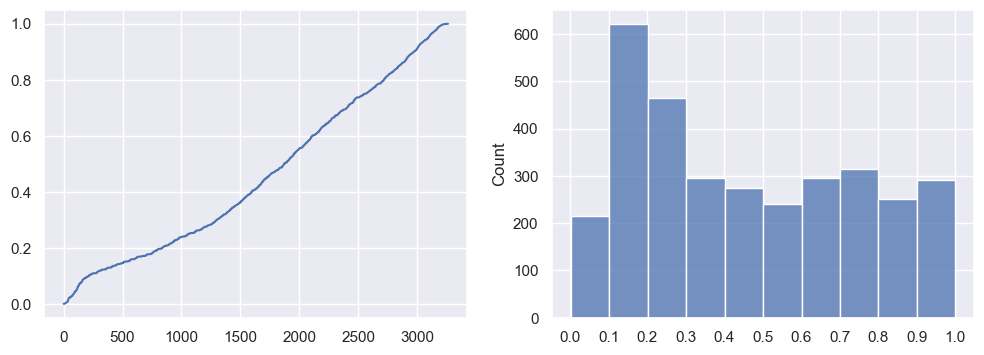

In [121]:
y_probs = lr.predict_proba(X_test)[:,1]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.lineplot(sorted(y_probs))
plt.subplot(1,2,2)
sns.histplot(y_probs, bins=10)
plt.xticks(np.linspace(0,1,11))
plt.show()

# Submission

In [82]:
# submission = pd.read_csv('sample_submission.csv')
# submission['target'] = y_pred
# print(submission.shape)
# submission.to_csv('submission_jg_8851.csv', index=False)

# Helpers and Old

In [83]:
# substring = 'Deeds'
# matches = X_train.astype(str).apply(lambda col: col.str.contains(substring, na=False))
# filtered_rows = X_train[matches.any(axis=1)]
# print("Rows with matches:\n", filtered_rows)
# locations = matches.stack()[matches.stack()]
# print("Locations of matches:\n", locations.index.tolist())

In [84]:
# features = ['features_stats', 'features_polys', 'features_te_ce', 'features_te_skl', 'features_cv_hashtags', 'features_cv_handles', 'features_cv_urls', 'features_tv']

# def all_combinations(iterable):
#     return chain.from_iterable(combinations(iterable, r) for r in range(1, len(iterable) + 1))

# feature_combinations = list(all_combinations(features))

In [85]:
# print(f'Training F1 score:\t{round(f1_score(y_train, lr.predict(X_train_scaled)),4)}')
# print(f'Training accuracy:\t{round(lr.score(X_train_scaled, y_train),4)}')
# cm = confusion_matrix(y_train, lr.predict(X_train_scaled))
# display(pd.DataFrame(cm,index=['Actual Negative', 'Actual Positive'],columns=['Predicted Negative', 'Predicted Positive']))
# display(pd.DataFrame((cm/cm.sum()*100).round(1),index=['Actual Negative (%)', 'Actual Positive (%)'],columns=['Predicted Negative (%)', 'Predicted Positive (%)']))

In [86]:
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# print(f'Cross-validated F1 score:\t{round(cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='f1').mean(),4)}')